In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings("ignore")

### 1. Downloading the S&P500 Stocks Price Data

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-12-06'

start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = yf.download(symbols_list, start=start_date, end=end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed


### 2. Calculate features and Techncal Indicators for Each Stock

In [3]:
# Garman-Klass Volatility

df['garman_klass'] = ((np.log(df['high'] / df['low'])) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2

In [4]:
# RSI

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

In [5]:
# Bollinger Bands

df['bb_lower'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,0])

df['bb_middle'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,1])

df['bb_upper'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,2])

In [6]:
# ATR

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df ['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [7]:
# MACD

def compute_macd(close):
    macd = pandas_ta.macd(close = close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [8]:
# Dollar Volume (in millions of Dollars)

df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month

- To reduse training time and experiment woth features and strategies, we convert the business-daily data to month-end frequency

- We take mean for Dollar Volume and Last for the other technical indicators

In [9]:
last_cols = [c for c in df.columns.unique(0) if c not in ['open', 'high', 'low', 'close', 'volume', 'dollar_volume']]

In [10]:
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1).dropna()

- Calculate 5-year rolling average of dollar volume for each stock before filtering

In [11]:
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

In [12]:
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

In [13]:
data = data[data['dollar_vol_rank'] < 150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1) # 150 stocks with highest dollar volume
data

adj close  garman_klass        rsi  bb_lower  bb_middle  \
date       ticker                                                             
2016-12-31 AAL      45.118092     -0.000637  52.919030  3.813338   3.856552   
           AAPL     26.946930     -0.002296  57.499185  3.274855   3.319664   
           ABBV     46.037792     -0.036939  54.830571  3.809937   3.836562   
           ABT      33.897526     -0.005705  45.324550  3.535751   3.555423   
           ACN     105.149269     -0.004741  44.676095  4.641425   4.692405   
...                       ...           ...        ...       ...        ...   
2023-12-31 VRTX    354.149994      0.000071  47.572861  5.822438   5.883687   
           VZ       38.419998      0.000071  70.861634  3.582293   3.634400   
           WFC      44.490002      0.000038  64.143819  3.714670   3.777957   
           WMT     155.153748      0.000085  42.903668  5.008750   5.074073   
           XOM     100.440002      0.000079  37.667220  4.625797   4.647071   

                   bb_upper       atr      macd  
date       ticker                                
2016-12-31 AAL     3.899765  1.512695  1.016526  
           AAPL    3.364473 -1.018895 -0.117794  
           ABBV    3.863187  0.455163 -0.009606  
           ABT     3.575095 -0.365580 -0.353417  
           ACN     4.743385  0.410502 -0.355571  
...                     ...       ...       ...  
2023-12-31 VRTX    5.944935  0.907017 -1.149526  
           VZ      3.686507 -2.090611  2.213681  
           WFC     3.841244 -1.457310  1.249704  
           WMT     5.139395 -2.044193 -1.682155  
           XOM     4.668345 -1.410654 -1.185900  

[12665 rows x 8 columns]

### 4. Calculate Monthly Returns for different time horizons as features
- To capture time series dynamics that reflect, for example, monthly patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified as lags

In [14]:
def calcuate_returns(df):
    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1)

    return df

data = data.groupby(level=1, group_keys=False).apply(calcuate_returns).dropna()
data

adj close  garman_klass        rsi  bb_lower  bb_middle  \
date       ticker                                                             
2017-12-31 AAL      50.711876     -0.000305  59.214239  3.884601   3.928729   
           AAPL     40.006565     -0.001526  47.784526  3.703448   3.728878   
           ABBV     73.694954     -0.031544  55.000890  4.289143   4.313943   
           ABT      51.533802     -0.004710  59.877737  3.904342   3.941390   
           ACN     140.201767     -0.003561  65.003667  4.907500   4.937618   
...                       ...           ...        ...       ...        ...   
2023-12-31 VRTX    354.149994      0.000071  47.572861  5.822438   5.883687   
           VZ       38.419998      0.000071  70.861634  3.582293   3.634400   
           WFC      44.490002      0.000038  64.143819  3.714670   3.777957   
           WMT     155.153748      0.000085  42.903668  5.008750   5.074073   
           XOM     100.440002      0.000079  37.667220  4.625797   4.647071   

                   bb_upper       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2017-12-31 AAL     3.972856  0.984891  1.248925   0.030501   0.055325   
           AAPL    3.754309 -0.678696 -0.228366  -0.015246   0.002359   
           ABBV    4.338743  1.680007  0.196950  -0.002167   0.035171   
           ABT     3.978439  0.315865  0.247936   0.012418   0.025851   
           ACN     4.967737  0.777819  0.286551   0.034322   0.037002   
...                     ...       ...       ...        ...        ...   
2023-12-31 VRTX    5.944935  0.907017 -1.149526  -0.001860  -0.011052   
           VZ      3.686507 -2.090611  2.213681   0.002348   0.045778   
           WFC     3.841244 -1.457310  1.249704  -0.002243   0.062382   
           WMT     5.139395 -2.044193 -1.682155   0.000257  -0.023782   
           XOM     4.668345 -1.410654 -1.185900  -0.022387  -0.021447   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2017-12-31 AAL      0.031653   0.006292   0.023994    0.009787  
           AAPL     0.032901   0.028535   0.019684    0.033479  
           ABBV     0.031007   0.051953   0.047851    0.039985  
           ABT      0.024323   0.028884   0.030147    0.035524  
           ACN      0.045983   0.037860   0.029824    0.024265  
...                      ...        ...        ...         ...  
2023-12-31 VRTX     0.006107   0.001058   0.013077    0.017150  
           VZ       0.059006   0.011971   0.004802    0.003815  
           WFC      0.031825   0.009747   0.022310    0.008827  
           WMT     -0.008832  -0.000953   0.006910    0.008806  
           XOM     -0.048281  -0.008024  -0.006856   -0.004993  

[10493 rows x 14 columns]

### 5. Download Fama-French Factors and Calculate Rolling Factors Betas
- Introducing the Fama_French Data to estimate the exposure of assets to common risk factors using linear regression
- The 5 Fama-French Factors: Market Risk Premium, Size, Value, Profitability & Investment, have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to incluse past factor exposures as financial features in models.
- We can access the historical returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [15]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=2010)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last()
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-3.36,0.34,0.43,-1.27,0.46
2010-02-28,3.40,1.51,3.23,-0.27,1.43
2010-03-31,6.31,1.85,2.21,-0.65,1.69
2010-04-30,2.00,4.98,2.89,0.69,1.72
2010-05-31,-7.89,0.04,-2.44,1.30,-0.21
...,...,...,...,...,...
2023-07-31,3.21,2.86,4.11,-0.57,0.57
2023-08-31,-2.39,-3.65,-1.06,3.43,-2.37
2023-09-30,-5.24,-1.80,1.52,1.86,-0.83


In [16]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF   SMB   HML   RMW   CMA  return_1m
date       ticker                                           
2017-12-31 AAL       1.06 -1.07  0.06  0.74  1.69   0.030501
           AAPL      1.06 -1.07  0.06  0.74  1.69  -0.015246
           ABBV      1.06 -1.07  0.06  0.74  1.69  -0.002167
           ABT       1.06 -1.07  0.06  0.74  1.69   0.012418
           ACN       1.06 -1.07  0.06  0.74  1.69   0.034322
...                   ...   ...   ...   ...   ...        ...
2023-11-30 VRTX      8.84 -0.10  1.65 -3.89 -0.99  -0.020160
           VZ        8.84 -0.10  1.65 -3.89 -0.99   0.091090
           WFC       8.84 -0.10  1.65 -3.89 -0.99   0.131192
           WMT       8.84 -0.10  1.65 -3.89 -0.99  -0.047243
           XOM       8.84 -0.10  1.65 -3.89 -0.99  -0.020506

[10347 rows x 6 columns]

- Filter out stocks with les than 10 months of data

In [17]:
observations = factor_data.groupby(level=1).size() 
valid_stocks = observations[observations > 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF   SMB   HML   RMW   CMA  return_1m
date       ticker                                           
2017-12-31 AAL       1.06 -1.07  0.06  0.74  1.69   0.030501
           AAPL      1.06 -1.07  0.06  0.74  1.69  -0.015246
           ABBV      1.06 -1.07  0.06  0.74  1.69  -0.002167
           ABT       1.06 -1.07  0.06  0.74  1.69   0.012418
           ACN       1.06 -1.07  0.06  0.74  1.69   0.034322
...                   ...   ...   ...   ...   ...        ...
2023-11-30 VRTX      8.84 -0.10  1.65 -3.89 -0.99  -0.020160
           VZ        8.84 -0.10  1.65 -3.89 -0.99   0.091090
           WFC       8.84 -0.10  1.65 -3.89 -0.99   0.131192
           WMT       8.84 -0.10  1.65 -3.89 -0.99  -0.047243
           XOM       8.84 -0.10  1.65 -3.89 -0.99  -0.020506

[10297 rows x 6 columns]

#### Rolling Factor Betas

In [18]:
betas = factor_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'], exog=sm.add_constant(x.drop('return_1m', axis=1)), window = min(24, x.shape[0]), min_nobs = len(x.columns)+1).fit(params_only=True).params.drop('const', axis=1))

In [19]:
data = data.join(betas.groupby('ticker').shift())
data

adj close  garman_klass        rsi  bb_lower  bb_middle  \
date       ticker                                                             
2017-12-31 AAL      50.711876     -0.000305  59.214239  3.884601   3.928729   
           AAPL     40.006565     -0.001526  47.784526  3.703448   3.728878   
           ABBV     73.694954     -0.031544  55.000890  4.289143   4.313943   
           ABT      51.533802     -0.004710  59.877737  3.904342   3.941390   
           ACN     140.201767     -0.003561  65.003667  4.907500   4.937618   
...                       ...           ...        ...       ...        ...   
2023-12-31 VRTX    354.149994      0.000071  47.572861  5.822438   5.883687   
           VZ       38.419998      0.000071  70.861634  3.582293   3.634400   
           WFC      44.490002      0.000038  64.143819  3.714670   3.777957   
           WMT     155.153748      0.000085  42.903668  5.008750   5.074073   
           XOM     100.440002      0.000079  37.667220  4.625797   4.647071   

                   bb_upper       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2017-12-31 AAL     3.972856  0.984891  1.248925   0.030501   0.055325   
           AAPL    3.754309 -0.678696 -0.228366  -0.015246   0.002359   
           ABBV    4.338743  1.680007  0.196950  -0.002167   0.035171   
           ABT     3.978439  0.315865  0.247936   0.012418   0.025851   
           ACN     4.967737  0.777819  0.286551   0.034322   0.037002   
...                     ...       ...       ...        ...        ...   
2023-12-31 VRTX    5.944935  0.907017 -1.149526  -0.001860  -0.011052   
           VZ      3.686507 -2.090611  2.213681   0.002348   0.045778   
           WFC     3.841244 -1.457310  1.249704  -0.002243   0.062382   
           WMT     5.139395 -2.044193 -1.682155   0.000257  -0.023782   
           XOM     4.668345 -1.410654 -1.185900  -0.022387  -0.021447   

                   return_3m  return_6m  return_9m  return_12m  Mkt-RF  SMB  \
date       ticker                                                             
2017-12-31 AAL      0.031653   0.006292   0.023994    0.009787     NaN  NaN   
           AAPL     0.032901   0.028535   0.019684    0.033479     NaN  NaN   
           ABBV     0.031007   0.051953   0.047851    0.039985     NaN  NaN   
           ABT      0.024323   0.028884   0.030147    0.035524     NaN  NaN   
           ACN      0.045983   0.037860   0.029824    0.024265     NaN  NaN   
...                      ...        ...        ...         ...     ...  ...   
2023-12-31 VRTX     0.006107   0.001058   0.013077    0.017150     NaN  NaN   
           VZ       0.059006   0.011971   0.004802    0.003815     NaN  NaN   
           WFC      0.031825   0.009747   0.022310    0.008827     NaN  NaN   
           WMT     -0.008832  -0.000953   0.006910    0.008806     NaN  NaN   
           XOM     -0.048281  -0.008024  -0.006856   -0.004993     NaN  NaN   

                   HML  RMW  CMA  
date       ticker                 
2017-12-31 AAL     NaN  NaN  NaN  
           AAPL    NaN  NaN  NaN  
           ABBV    NaN  NaN  NaN  
           ABT     NaN  NaN  NaN  
           ACN     NaN  NaN  NaN  
...                ...  ...  ...  
2023-12-31 VRTX    NaN  NaN  NaN  
           VZ      NaN  NaN  NaN  
           WFC     NaN  NaN  NaN  
           WMT     NaN  NaN  NaN  
           XOM     NaN  NaN  NaN  

[10493 rows x 19 columns]

In [20]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()

In [21]:
data = data.drop('adj close', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10259 entries, (Timestamp('2017-12-31 00:00:00'), 'AAL') to (Timestamp('2023-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   garman_klass  10259 non-null  float64
 1   rsi           10259 non-null  float64
 2   bb_lower      10259 non-null  float64
 3   bb_middle     10259 non-null  float64
 4   bb_upper      10259 non-null  float64
 5   atr           10259 non-null  float64
 6   macd          10259 non-null  float64
 7   return_1m     10259 non-null  float64
 8   return_2m     10259 non-null  float64
 9   return_3m     10259 non-null  float64
 10  return_6m     10259 non-null  float64
 11  return_9m     10259 non-null  float64
 12  return_12m    10259 non-null  float64
 13  Mkt-RF        10259 non-null  float64
 14  SMB           10259 non-null  float64
 15  HML           10259 non-null  float64
 16  RMW           10259 non-null  float6

- Now, from each month, we'll create a portfolio with some of these stocks on our list

### 6. For each month, fit a K-Means Clustering Algorithm to group similar assets based on their features
#### K-Means Clustering
- K-Means is a clustering algorithm that aims to partition n observations into k clusters. There are 3 steps:
    - Initialisation – K initial “means” (centroids) are generated at random
    - Assignment – K clusters are created by associating each observation with the nearest centroid
    - Update – The centroid of the clusters becomes the new mean
    - Assignment and Update are repeated iteratively until convergence
    - The end result is that the sum of squared errors is minimised between points and their respective centroids
- In this tutorial, the dude initially relied on the 'k-means++' initialization

In [22]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init='random').fit(df).labels_
    return df

In [23]:
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass        rsi  bb_lower  bb_middle  bb_upper  \
date       ticker                                                           
2017-12-31 AAL        -0.000305  59.214239  3.884601   3.928729  3.972856   
           AAPL       -0.001526  47.784526  3.703448   3.728878  3.754309   
           ABBV       -0.031544  55.000890  4.289143   4.313943  4.338743   
           ABT        -0.004710  59.877737  3.904342   3.941390  3.978439   
           ACN        -0.003561  65.003667  4.907500   4.937618  4.967737   
...                         ...        ...       ...        ...       ...   
2023-12-31 VRTX        0.000071  47.572861  5.822438   5.883687  5.944935   
           VZ          0.000071  70.861634  3.582293   3.634400  3.686507   
           WFC         0.000038  64.143819  3.714670   3.777957  3.841244   
           WMT         0.000085  42.903668  5.008750   5.074073  5.139395   
           XOM         0.000079  37.667220  4.625797   4.647071  4.668345   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-12-31 AAL     0.984891  1.248925   0.030501   0.055325   0.031653   
           AAPL   -0.678696 -0.228366  -0.015246   0.002359   0.032901   
           ABBV    1.680007  0.196950  -0.002167   0.035171   0.031007   
           ABT     0.315865  0.247936   0.012418   0.025851   0.024323   
           ACN     0.777819  0.286551   0.034322   0.037002   0.045983   
...                     ...       ...        ...        ...        ...   
2023-12-31 VRTX    0.907017 -1.149526  -0.001860  -0.011052   0.006107   
           VZ     -2.090611  2.213681   0.002348   0.045778   0.059006   
           WFC    -1.457310  1.249704  -0.002243   0.062382   0.031825   
           WMT    -2.044193 -1.682155   0.000257  -0.023782  -0.008832   
           XOM    -1.410654 -1.185900  -0.022387  -0.021447  -0.048281   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-12-31 AAL      0.006292   0.023994    0.009787  0.012572  0.013484   
           AAPL     0.028535   0.019684    0.033479  0.012985 -0.003014   
           ABBV     0.051953   0.047851    0.039985  0.004775  0.004246   
           ABT      0.028884   0.030147    0.035524  0.008185 -0.001671   
           ACN      0.037860   0.029824    0.024265  0.012098 -0.001685   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.001058   0.013077    0.017150  0.005348  0.000508   
           VZ       0.011971   0.004802    0.003815  0.004940 -0.003595   
           WFC      0.009747   0.022310    0.008827  0.010826 -0.000980   
           WMT     -0.000953   0.006910    0.008806  0.006158 -0.004506   
           XOM     -0.008024  -0.006856   -0.004993  0.011443  0.002782   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-12-31 AAL     0.005584  0.003540  0.006342        3  
           AAPL   -0.006051  0.005999  0.005251        1  
           ABBV   -0.000715  0.003033  0.002344        2  
           ABT    -0.005207  0.002815  0.009816        3  
           ACN    -0.003161  0.002819  0.001731        3  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.009301  0.000382  0.008538        1  
           VZ      0.000698  0.002963  0.005085        3  
           WFC     0.014122 -0.007288 -0.005728        3  
           WMT    -0.003126  0.003226  0.007127        2  
           XOM     0.006475 -0.004837  0.006797        2  

[10259 rows x 19 columns]

In [24]:
def plot_clusters(data):
    
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
# In the plot, the x-axis is ATR and the y-axis is RSI
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color = 'red', label = 'Cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color = 'green', label = 'Cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color = 'blue', label = 'Cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color = 'black', label = 'Cluster 3')
    
    plt.legend()
    plt.show()
    return

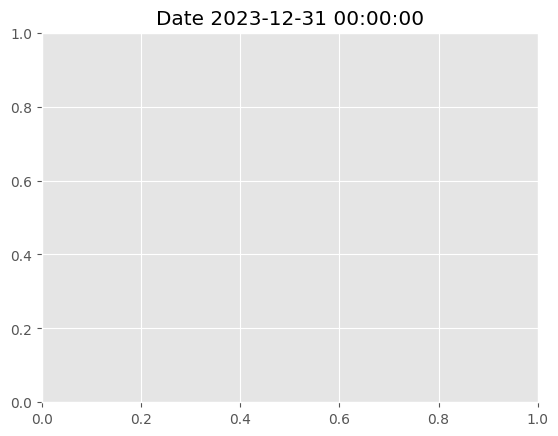

In [29]:
plt.style.use('ggplot')

for i in  data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    #plot_clusters(g)

- We want the centroid centers to be based on our RSI indicators

In [30]:
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18)) # We have 18 features
initial_centroids[:, 1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [31]:
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_
    return df

In [32]:
data = data.drop('cluster', axis = 1)

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass        rsi  bb_lower  bb_middle  bb_upper  \
date       ticker                                                           
2017-12-31 AAL        -0.000305  59.214239  3.884601   3.928729  3.972856   
           AAPL       -0.001526  47.784526  3.703448   3.728878  3.754309   
           ABBV       -0.031544  55.000890  4.289143   4.313943  4.338743   
           ABT        -0.004710  59.877737  3.904342   3.941390  3.978439   
           ACN        -0.003561  65.003667  4.907500   4.937618  4.967737   
...                         ...        ...       ...        ...       ...   
2023-12-31 VRTX        0.000071  47.572861  5.822438   5.883687  5.944935   
           VZ          0.000071  70.861634  3.582293   3.634400  3.686507   
           WFC         0.000038  64.143819  3.714670   3.777957  3.841244   
           WMT         0.000085  42.903668  5.008750   5.074073  5.139395   
           XOM         0.000079  37.667220  4.625797   4.647071  4.668345   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-12-31 AAL     0.984891  1.248925   0.030501   0.055325   0.031653   
           AAPL   -0.678696 -0.228366  -0.015246   0.002359   0.032901   
           ABBV    1.680007  0.196950  -0.002167   0.035171   0.031007   
           ABT     0.315865  0.247936   0.012418   0.025851   0.024323   
           ACN     0.777819  0.286551   0.034322   0.037002   0.045983   
...                     ...       ...        ...        ...        ...   
2023-12-31 VRTX    0.907017 -1.149526  -0.001860  -0.011052   0.006107   
           VZ     -2.090611  2.213681   0.002348   0.045778   0.059006   
           WFC    -1.457310  1.249704  -0.002243   0.062382   0.031825   
           WMT    -2.044193 -1.682155   0.000257  -0.023782  -0.008832   
           XOM    -1.410654 -1.185900  -0.022387  -0.021447  -0.048281   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-12-31 AAL      0.006292   0.023994    0.009787  0.012572  0.013484   
           AAPL     0.028535   0.019684    0.033479  0.012985 -0.003014   
           ABBV     0.051953   0.047851    0.039985  0.004775  0.004246   
           ABT      0.028884   0.030147    0.035524  0.008185 -0.001671   
           ACN      0.037860   0.029824    0.024265  0.012098 -0.001685   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.001058   0.013077    0.017150  0.005348  0.000508   
           VZ       0.011971   0.004802    0.003815  0.004940 -0.003595   
           WFC      0.009747   0.022310    0.008827  0.010826 -0.000980   
           WMT     -0.000953   0.006910    0.008806  0.006158 -0.004506   
           XOM     -0.008024  -0.006856   -0.004993  0.011443  0.002782   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-12-31 AAL     0.005584  0.003540  0.006342        2  
           AAPL   -0.006051  0.005999  0.005251        0  
           ABBV   -0.000715  0.003033  0.002344        1  
           ABT    -0.005207  0.002815  0.009816        2  
           ACN    -0.003161  0.002819  0.001731        2  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.009301  0.000382  0.008538        1  
           VZ      0.000698  0.002963  0.005085        3  
           WFC     0.014122 -0.007288 -0.005728        3  
           WMT    -0.003126  0.003226  0.007127        0  
           XOM     0.006475 -0.004837  0.006797        0  

[10259 rows x 19 columns]

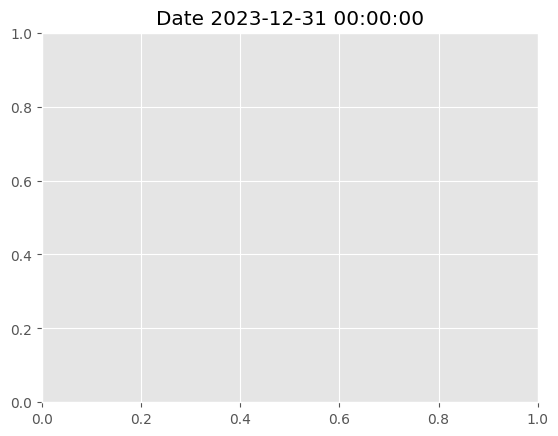

In [34]:
plt.style.use('ggplot')

for i in  data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    #plot_clusters(g)

### 7. For each month, we'll select assets based on the cluster and form a portfolio based on Effecient Frontier max sharpe ratio optimization
- First, we'll filter only stocks corresponding to the cluster we choose based on our hypothesis.
- Momentum is persistent and my idea would be that stocks clustered around RSI 70 cnetroid should continue to outperform in the next month

In [47]:
filtered_df = data[data['cluster'] == 3].copy()
filtered_df = filtered_df.reset_index(level = 1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()

In [48]:
fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()
fixed_dates

{'2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PXD',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TX

#### Define Portfolio Optimization Function
- We'll ise PyPortfolioOpt and EffecientFrontier to optimize our portfolio by maximising the Sharpe Ratio.
- To optimize the weights of our portfolio, we'll supply last 1 year prices to the function.
- Apply single stock weight bounds constraint for diversification (minimum half of equally weighted and maximum 10% of portfolio)

In [49]:
from pypfopt import EfficientFrontier, risk_models, expected_returns

In [61]:
def optimize_weight(prices, lower_bound):
    
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, 1), solver='SCS') 
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()   

- We'll download fresh daily prices data only for short listed stocks

In [54]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-03  44.741226   27.023706   45.883408   34.462353  104.547798   
2017-01-04  45.127766   26.993452   46.530376   34.735924  104.799156   
2017-01-05  44.345036   27.130730   46.883266   35.035992  103.228172   
2017-01-06  44.654263   27.433191   46.897968   35.989109  104.404175   
2017-01-09  45.494968   27.684464   47.206760   35.953804  103.237144   
...               ...         ...         ...         ...         ...   
2023-12-22  14.310000  193.600006  154.940002  109.029999  354.450012   
2023-12-26  14.110000  193.050003  154.619995  109.230003  353.429993   
2023-12-27  13.990000  193.149994  154.880005  109.790001  353.820007   
2023-12-28  13.980000  193.580002  154.750000  110.400002  351.589996   
2023-12-29  13.740000  192.529999  154.970001  110.070000  350.910004   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-03  103.480003   89.319763   76.180000  54.072819   29.419781  ...   
2017-01-04  104.139999   89.457855   77.519997  54.778629   29.696114  ...   
2017-01-05  105.910004   88.922798   76.930000  54.471394   29.567150  ...   
2017-01-06  108.300003   88.983208   79.300003  55.476109   29.511890  ...   
2017-01-09  108.570000   88.430870   79.589996  55.119049   30.193495  ...   
...                ...         ...         ...        ...         ...  ...   
2023-12-22  598.750000  230.970001  242.759995  66.930000  162.050003  ...   
2023-12-26  598.260010  232.539993  245.070007  67.129997  164.279999  ...   
2023-12-27  596.080017  231.610001  245.110001  67.150002  164.210007  ...   
2023-12-28  595.520020  232.490005  244.910004  67.870003  163.119995  ...   
2023-12-29  596.599976  232.970001  243.479996  67.750000  162.070007  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-01-03  13785200  4425000  1761900  22891700   4942700  4479000  22063800   
2017-01-04   8033100  7431000  1667700  18316100   4125500  3653200  15036100   
2017-01-05   7805100  6450600  2354700  13840600   7401400  3638300  18831600   
2017-01-06   8898300  3771700  1669800  15615000   3949700  3274300  18715900   
2017-01-09   7305300  5132600  4522500  14097200   3293000  3909600  21794100   
...              ...      ...      ...       ...       ...      ...       ...   
2023-12-22   5111500  2279000   804200  13157900   9776300  2936500  10448000   
2023-12-26   2085100  1807100   531600  11856600  10181100  2010800   8856600   
2023-12-27   4034700  1358000   594000  15267600   8265500  2167200  12536700   
2023-12-28   3020500  1661200   735600  14931700   7899900  4200000   9872600   
2023-12-29   4074600  1963400   727400  16205200  10853300  3478100  11731900   

                                         
                 WMT     WYNN       XOM  
Date                                     
2017-01-03  10473200  2703500  10360600  
2017-01-04   7918000  2598800   9434200  
2017-01-05   7099200  2507500  14443200  
2017-01-06   9491100  1858400  16518100  
2017-01-09   8685200  2776200  13762300  
...              ...      ...       ...  
2023-12-22   6467400  1170500  12921800  
2023-12-26   3893300  1150000  16835100  
2023-12-27   6632000  1142200  14558800  
2023-12-28   5592000  1233000  16329300  
2023-12-29   7314200  1144800  17741400  

[1760 rows x 930 columns]

- Calculate daily returns for each stock which could land up in our portfolio
- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
- If the max sharpe ratio optimization fails to converge, we'll use equally weighted portfolio
- Calculated each day portfolio return.

In [56]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
returns_dataframe

,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADP,ADSK,AIG,AMAT,...,V,VLO,VRTX,VZ,WBA,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008602,-0.001120,0.014002,0.007907,0.002401,0.006358,0.001545,0.017437,0.012969,0.009349,...,0.008143,-0.036588,0.028434,-0.001100,0.000241,0.015861,0.000892,0.005809,0.031734,-0.011064
2017-01-05,-0.017497,0.005073,0.007555,0.008601,-0.015104,0.016854,-0.005999,-0.007640,-0.005624,-0.004352,...,0.011660,-0.003098,0.025752,0.002199,0.000602,0.000142,-0.015643,0.002169,0.012767,-0.015019
2017-01-06,0.006949,0.011087,0.000314,0.026840,0.011328,0.022315,0.000679,0.030342,0.018277,-0.001871,...,0.013717,-0.015186,0.004165,-0.014946,0.000842,-0.002413,-0.002541,-0.013821,0.010769,-0.000565
2017-01-09,0.018652,0.009118,0.006563,-0.000981,-0.011241,0.002490,-0.006227,0.003650,-0.006457,0.022833,...,-0.005611,-0.004360,0.042780,-0.010949,-0.006640,0.020811,-0.014642,0.006571,0.003456,-0.016635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.002791,-0.005563,0.015283,0.005057,0.016212,-0.002319,0.008609,0.003590,0.005393,0.004081,...,-0.004286,0.002120,0.011466,0.001602,0.006121,0.005331,-0.005475,0.011880,-0.003312,0.001768
2023-12-26,-0.014075,-0.002845,-0.002067,0.001833,-0.002882,-0.000819,0.006774,0.009471,0.002984,0.013667,...,0.002821,0.007461,0.005929,-0.000267,0.014765,0.001897,0.009310,-0.001533,0.006394,0.002254
2023-12-27,-0.008541,0.000518,0.001680,0.005114,0.001103,-0.003651,-0.004007,0.000163,0.000298,-0.000426,...,-0.000888,-0.010339,0.000956,-0.004546,0.001127,-0.006465,-0.006264,0.009354,-0.004074,-0.004710


In [67]:
optimization_df = new_df['2017-01-01':'2017-12-31']['Adj Close'][fixed_dates['2018-01-01']]
optimization_df

,BA,CAT,CVX,DE,FCX,FDX,HAL,HD,LOW,LUV,MAR,OXY,PXD,RTX,STZ,TXN,UAL,UNP,VLO
Date,,,,,,,,,,,,,,,,,,,
2017-01-03,145.533646,79.011276,87.587738,93.223633,12.850872,169.431061,49.083916,113.506989,62.386341,46.881813,77.736931,58.585857,146.261505,58.890774,140.412216,60.891830,72.709999,87.958534,52.196770
2017-01-04,147.063461,78.658180,87.565483,94.809471,13.830073,170.342682,49.269035,114.512634,63.142536,48.119984,77.586159,57.945457,144.356766,58.927948,143.352066,60.817345,73.019997,88.490494,50.321491
2017-01-05,147.146896,78.179031,87.186409,94.388359,13.634232,170.071930,49.551128,113.160461,62.491856,47.341442,77.058495,57.248295,145.556000,59.167099,133.153458,60.345631,70.930000,87.623932,50.165825
2017-01-06,147.508499,78.212654,86.837120,95.409775,13.895352,171.732803,49.947819,112.847763,62.386341,46.834911,77.548500,57.621197,145.062256,59.804722,135.594238,61.363518,71.370003,88.533394,49.409786
2017-01-09,146.785324,77.649445,86.093903,94.245010,13.690188,171.227325,49.427711,113.506989,62.491856,47.181980,77.501350,57.134808,143.126221,59.246788,136.347290,61.520771,71.279999,87.872757,49.194828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,281.228180,134.872375,96.577408,143.323898,16.879595,227.699097,43.011837,162.654083,81.784462,62.388664,127.830147,62.072807,134.192734,69.206497,205.256134,88.352432,67.250000,118.011536,70.288147
2017-12-26,281.475952,135.469879,97.350143,144.433884,17.411158,227.353027,43.692715,164.582138,82.412262,62.398109,127.190857,62.540565,136.443375,69.157516,206.815201,88.369400,67.349998,118.169479,70.851196
2017-12-27,281.723785,136.405075,97.017853,144.279190,17.429810,227.708206,43.737507,164.435196,82.609573,62.379192,130.005630,62.353466,135.227875,69.396843,207.246231,88.691826,67.120003,119.635086,71.067169


In [98]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        
        optimization_start_date = pd.to_datetime(start_date) - pd.DateOffset(months=12)
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weight(optimization_df, round(1/(len(optimization_df.columns)*2), 3))
            weights = pd.DataFrame(weights, index = pd.Series(0))
            success = True
        except:
            print(f'Optimization failed for {start_date}, continuing with equal weights')
        
        if success == False:
            weights = pd.DataFrame([1/(len(optimization_df.columns)) for i in range(len(optimization_df.columns))], index=optimization_df.columns.tolist(), columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                left_index=True, right_index=True)\
                .reset_index().set_index(['Date', 'index']).unstack().stack()
                
        temp_df.index.names = ['date', 'ticker']
        
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)
        continue
portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

Optimization failed for 2020-03-01, continuing with equal weights
Optimization failed for 2020-04-01, continuing with equal weights
Optimization failed for 2022-10-01, continuing with equal weights
'return'


,Strategy Return
date,
2018-01-02,0.003373
2018-01-03,0.006385
2018-01-04,-0.000150
2018-01-05,0.010174
2018-01-08,0.002666
...,...
2023-12-22,0.001847
2023-12-26,0.004310
2023-12-27,0.007001


<Axes: xlabel='date'>

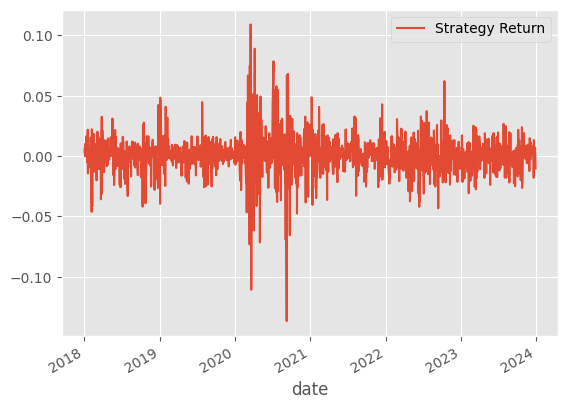

In [99]:
portfolio_df.plot()

### 8. Comparing Portfolio returns with the SP500 returns

In [103]:
spy = yf.download(tickers='SPY',start = '2015-01-01', end = dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename(columns={'Adj Close':'SPY Buy&Hold'})

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-01-02,0.003373,0.007132
2018-01-03,0.006385,0.006305
2018-01-04,-0.000150,0.004206
2018-01-05,0.010174,0.006642
2018-01-08,0.002666,0.001827
...,...,...
2023-12-22,0.001847,0.002008
2023-12-26,0.004310,0.004214
2023-12-27,0.007001,0.001806
2023-12-28,-0.001194,0.000378


In [107]:
import matplotlib.ticker as mtick


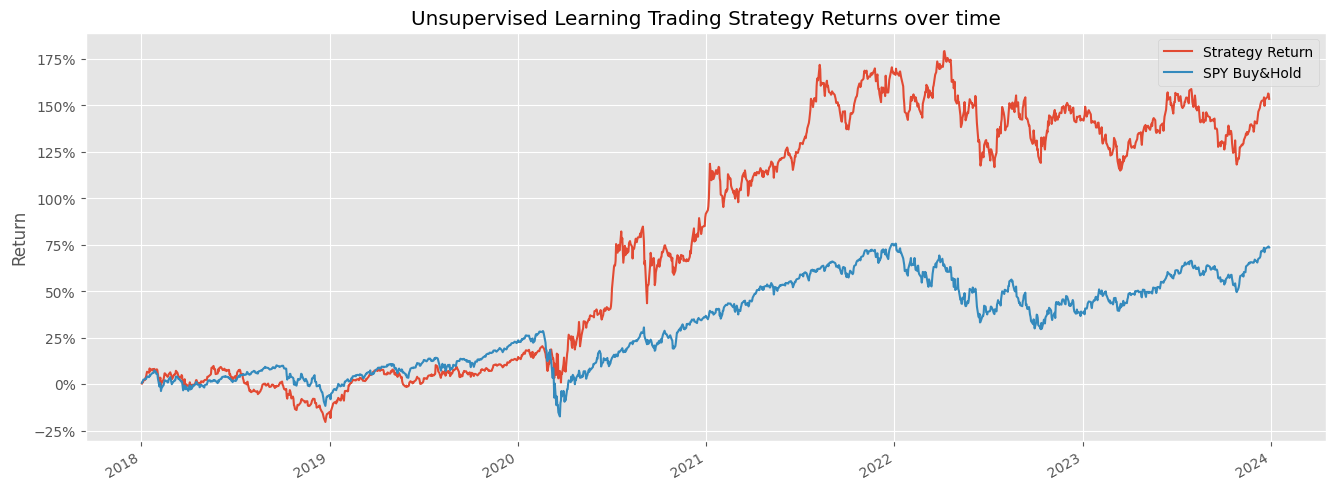

In [110]:
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumulative_return.plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Return')

plt.show()